<img src="https://www.digitale-medizin.net/img/Main_Day1_Healthcare_MOV8_Patient_v06.gif" alt="header_image"
	title="dmhd" width=100% height="200px"/>

<h1 style="font-size:45px">Digitale Medizin: Primer on Radiomics</h1>

In this tutorial we will focus on three things:
- Analyzing 2D image data
- Segmenting liver lesions
- Conducting a simple feature calculation

Jupyter Notebooks allow for a rich, interactive programming experience with different programming languages (e.g., Python, R, SAS). In this tutorial we will use Python, a common, versatile scripting language that is - perhaps- the current international standard in scientific computing, including machine learning and health data analysis applications.

__To execute the code in a cell hit the 'Run' button above or `Ctrl + K`.__

Most scripts start with imports of libraries, that provide additional functionality, needed to run the code. 

_Go ahead, select the next cell and run it to import the libraries we will need for this tutorial._

In [91]:
import nrrd
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import describe
from simple_segmenter import make_simple_segmenter
from base64 import b64decode
from PIL import Image
from io import BytesIO
from skimage.measure import perimeter

## 1. Analyzing 2D Image Data

The image we are working with is from a public dataset of livers with lesions (LiTS). To start, let's make a variable specifying where the image is located. Then we will load the image and convert it to a matrix (array) of numbers, before analyzing them.

In [37]:
image_path = './data/lits_liver.png'

In [40]:
image = Image.open(image_path)
image_array = np.array(image) 

In [44]:
# the size of the image and the shape of the corresponding array
print('The size of the image is: ', image.size)
print('The size of the array is: ', image_array.shape)

The size of the image is:  (512, 512)
The size of the array is:  (512, 512, 4)


In [62]:
# let us look at poin in the gray-scale array to get sense of what it means
print('A center point in the 4D gray-scale array:', image_array[256, 256, :])

A center point in the 4D gray-scale array: [211 211 211 255]


We can see four channels in the image: RGB (red, green, blue) + A (alpha)

The A channel regulates the transparency of the image. When working with segmentation masks, that we want to display above original images, this is an important piece of information to bear in mind.

Original DICOM image data (or data stored in NiFTY or NRRD files) is not mapped onto the 8 bit interval (0-255). Instead, it is often recorded in 12 bit (0-4095) and linearly transformed according to $f(x) = x - 1024$. Thus, the Hounsfield Unit of -1024 for air can be represented. 

In preparing this tutorial, the original DICOM image was converted and mapped to (0-255). Additionally, since we are working with gray-scale images, the first three channels are identical.

_Questions:_
- What information do we not have in a simple array of pixel values?

### 1.1 Let us calculate some descriptive statistics for our image

In [64]:
image_array[..., 0].shape

(512, 512)

In [65]:
# to describe our array we can use the scipy describe package, which we have imported
describe(image_array[..., 0].flatten())

DescribeResult(nobs=262144, minmax=(0, 255), mean=50.19119644165039, variance=5108.56604999236, skewness=1.1534018163260666, kurtosis=-0.06894553552158467)

__A very common way to analyze image information is to look at the histogram of pixel values.__

<module 'matplotlib.pyplot' from '/home/jacob/.pyenv/versions/3.7.4/envs/dmhd/lib/python3.7/site-packages/matplotlib/pyplot.py'>

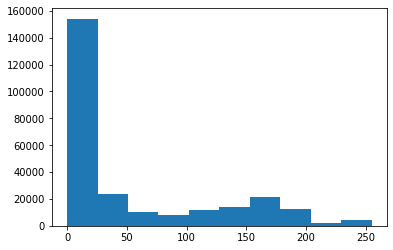

In [69]:
plt.hist(image_array[..., 0].flatten())
plt

_Questions:_
- In which scenarios do want to use histogram information?

## 2. Segmenting a 2D Image

We have built a very simple segmentation tool for you. To make segmentations, run the next cell. In the image click the left mouse button and keep it pressed to circle an area to be segmented. Once you are finished, click the 'Get Segmentation Mask' button and you will have the segmentation information stored in the variable `dataURL`.

In [70]:
make_simple_segmenter(image_path)

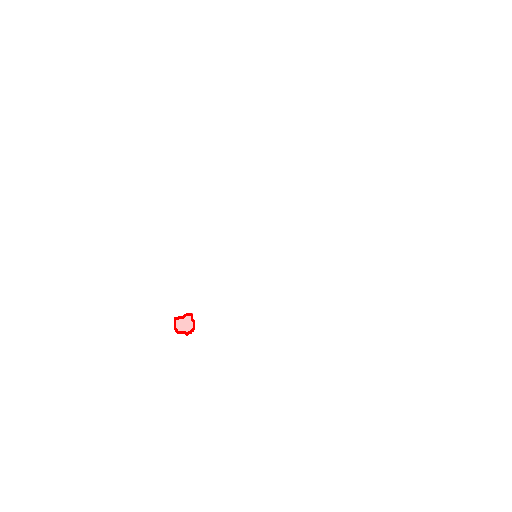

In [72]:
segmentation_mask = Image.open(BytesIO(b64decode(dataURL.split(',')[1])))
segmentation_mask

__Important:__ So what is a segmentation mask? What we see above and what is stored in the variable `segmentation_mask` is again an RGBA image. However, ultimately we want a matrix of 1s and 0s of the same size as the image. This will allow us to piece-wise multiply the two matrices and to isolate only those pixels that have a corresponding mask value of 1.

For example:

$ \begin{bmatrix}2 & 3 & 7 \\ 4 & 8 & 8\\ 2 & 5 & 1 \end{bmatrix} \odot \begin{bmatrix}0 & 0 & 1 \\ 0 & 1 & 1\\ 0 & 0 & 1 \end{bmatrix} = \begin{bmatrix}0 & 0 & 7 \\ 0 & 8 & 8\\ 0 & 0 & 1 \end{bmatrix} $

Therefore, we convert the RGBA mask to a binary array.

In [83]:
# convert segmentation to binary mask
segmentation_mask_array = np.array(segmentation_mask)
binary_segmentation_mask = np.sum(segmentation_mask_array[..., :3], axis=-1) != 0
binary_segmentation_mask = binary_segmentation_mask.astype('int8')

In [84]:
# load original image for header and save segmentation
img_data, img_head = nrrd.read('./data/lits_liver.nrrd')
nrrd.write('./data/lits_liver_segmentation.nrrd', binary_segmentation_mask, header=img_head)

## 3. Running a Simple Feature Extraction

### 3.1 Simple Features

Simple features of the lesion can be calculated solely based on the segmentation mask. Two such features, that we want to calculate here are _PixelsInLesion_ and _LesionPerimeter_.

In [85]:
def pixels_in_lesion(binary_segmentation_mask):
    return np.sum(binary_segmentation_mask)

In [86]:
pixels_in_lesion(binary_segmentation_mask)

384

In [92]:
def lesion_perimeter(binary_segmentation_mask):
    return perimeter(binary_segmentation_mask)

In [93]:
lesion_perimeter(binary_segmentation_mask)

75.21320343559643

### 3.2 Complex Features

More complex features can be caluculated with a variety of tools, i.e., 3D Slicer, MITK, MintMedical. A commonly used libarary for Python is pyradiomics, which is what we will use.

In [96]:
import os

import SimpleITK as sitk
import six

from radiomics import featureextractor

In [99]:
nrrd_image_path = './data/lits_liver.nrrd'
nrrd_segmentation_path = './data/lits_liver_segmentation.nrrd'

In [100]:
extractor = featureextractor.RadiomicsFeatureExtractor()
result = extractor.execute(nrrd_image_path, nrrd_segmentation_path)
for key, val in six.iteritems(result):
  print("\t%s: %s" %(key, val))

Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


	diagnostics_Versions_PyRadiomics: 2.2.0
	diagnostics_Versions_Numpy: 1.17.4
	diagnostics_Versions_SimpleITK: 1.2.4
	diagnostics_Versions_PyWavelet: 1.0.0
	diagnostics_Versions_Python: 3.7.4
	diagnostics_Configuration_Settings: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
	diagnostics_Configuration_EnabledImageTypes: {'Original': {}}
	diagnostics_Image-original_Hash: b51487610a3459f9785662535f72609587c54436
	diagnostics_Image-original_Dimensionality: 2D
	diagnostics_Image-original_Spacing: (1.0, 1.0)
	diagnostics_Image-original_Size: (512, 512)
	diagnostics_Image-original_Mean: 50.24042892456055
	diagnostics_Image-original_Minimum: 0.0
	diagnostics_Image-original_Maximum: 255.0
	diagnostics_Mask-origin

# 4. Conclusion

The next steps would be use the features extracted above for many different liver lesions in order to build a model that accurately classifies lesions with characteristics of interest.